In [2]:
import sys
#sys.path.insert(0,'/home/gigli/librascal/build/rascal/')

%matplotlib inline
from matplotlib import pylab as plt


import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.geometry.analysis import Analysis

from ase.visualize import view
import numpy as np
# If installed -- not essential, though
#try:
from tqdm.notebook import tqdm
#except ImportError:
    #tqdm = (lambda i, **kwargs: i)

from time import time

import skcosmo
import rascal
import sklearn
from rascal.models import Kernel, train_gap_model, compute_KNM, KRR
from rascal.representations import SphericalInvariants
from rascal.utils import from_dict, to_dict, CURFilter, FPSFilter, dump_obj, load_obj, get_score

import pickle as pk


#import quippy
#from quippy import potential
#
#import dftbplus
#from dftbplus import DftbPlus

Load the structures. Energy thresholds are chosen in such a way as to exclude outliers, e.g. non-physical structures, which might skew the training set.

# Loading the dataset 

In [3]:
np.random.permutation(10)

array([3, 0, 8, 2, 4, 5, 1, 9, 7, 6])

In [4]:
LiPSdataset = read('input.xyz',':',format='extxyz')
Ndataset = len(LiPSdataset)
np.random.seed(50)
index = np.random.permutation(Ndataset)
LiPSdataset = [LiPSdataset[i] for i in index]

In [5]:
LiPSdataset[0].get_potential_energy(),Ndataset

(-133338.765739, 662)

In [6]:
energiesXTB = np.array([snap.get_potential_energy() for snap in LiPSdataset ])
forcesXTB = np.array([snap.get_forces() for snap in LiPSdataset ],dtype=object)

In [7]:
forcesXTB_fl = np.concatenate(forcesXTB).ravel()




In [7]:
species = set()
for frame in LiPSdataset:
    species.update(frame.get_atomic_numbers())
species = np.sort(np.array(list(species)))

N_el = np.zeros((len(LiPSdataset), len(species)), dtype=int)
Natoms = np.zeros((len(LiPSdataset), 1), dtype=int)
atom_numbers = []

for i, frame in enumerate(LiPSdataset):
    atom_numbers = frame.get_atomic_numbers()
    Natoms[i] = frame.get_global_number_of_atoms()
    for j, s in enumerate(species):
        for el in atom_numbers:
            if(s == el): 
                N_el[i, j] += 1

In [8]:
#energies_coesXTB = np.loadtxt('isolated_atom/PBEsol/atomic_energies_PBEsol.dat')
#print(Ndataset,energies_coesXTB)
#energies_coesiveXTB = np.array([np.sum(N_el[i]*energies_coesXTB) for i in range(Ndataset)])
#
#energiesXTB_mencoes = energiesXTB - np.array([np.sum(N_el[i]*energies_coesXTB) for i in range(Ndataset)])

2256 [-202.4559868  -190.78526508 -284.60813356]


In [9]:
#LiPSdataset[0].info
LiPSdatasetPBEsol_mencoes = []

for ii,(snap,e) in enumerate(zip(LiPSdataset,energiesXTB_mencoes)):
    LiPSdatasetPBEsol_mencoes.append(snap)
    LiPSdatasetPBEsol_mencoes[ii].info['energy'] = e
    LiPSdatasetPBEsol_mencoes[ii].info['free_energy'] = e
    
    

In [10]:
len(LiPSdatasetPBEsol_mencoes),LiPSdatasetPBEsol_mencoes[0].info['energy']

(2256, -2.948176277463972)

In [8]:

av_forces = np.mean(forcesXTB_fl)
sigma_forces = np.std(forcesXTB_fl)

av_energies = np.mean(energiesXTB)
sigma_energies = np.std(energiesXTB)

print("Shape of the full input vector: ", forcesXTB_fl.shape[0] + energiesXTB.shape[0])
print("Mean & STD energies/atom = ", av_energies, " ", sigma_energies, " eV")
print("Mean & STD forces = ", av_forces, " ", sigma_forces, " eV/Angstrom")

Shape of the full input vector:  953942
Mean & STD energies/atom =  -133317.20597238973   15.915361483739995  eV
Mean & STD forces =  7.03675730072458e-09   0.8208911428305201  eV/Angstrom


The very large variances on atomic energies that one sees are due to the fact that the $\alpha$ phase has a different 
stoichiometry w.r.t. to $\beta$ and $\gamma$. The loss of one Li atoms accounts for the difference.

In [9]:
for f in tqdm(LiPSdataset):
    f.wrap(eps=1e-18)

  0%|          | 0/662 [00:00<?, ?it/s]

In [10]:
Ndataset = len(LiPSdataset)
print(Ndataset)

662


(array([3.18717880e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.18717880e-05,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.37435759e-05,
        3.18717880e-05, 3.18717880e-05, 3.18717880e-05, 0.00000000e+00,
        3.18717880e-05, 6.37435759e-05, 3.18717880e-05, 0.00000000e+00,
        0.00000000e+00, 3.18717880e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 3.18717880e-05, 3.18717880e-05,
        6.37435759e-05, 6.37435759e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 3.18717880e-05, 0.00000000e+00,
        3.18717880e-05, 3.18717880e-05, 0.00000000e+00, 3.18717880e-05,
        3.18717880e-05, 3.18717880e-05, 9.56153639e-05, 0.000000

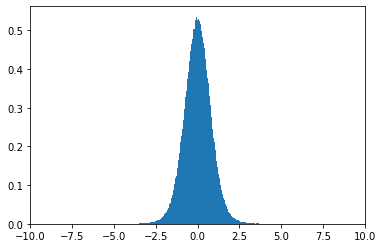

In [11]:

fig, ax = plt.subplots(nrows=1, ncols=1)

ax.set_xlim(-10.0, 10.0)
ax.hist(forcesXTB_fl, bins=500, density=True)

# ML baseline + GAPs

In [12]:
species = set()
for frame in LiPSdataset:
    species.update(frame.get_atomic_numbers())
species = np.sort(np.array(list(species)))

N_el = np.zeros((len(LiPSdataset), len(species)), dtype=int)
Natoms = np.zeros((len(LiPSdataset), 1), dtype=int)
atom_numbers = []

for i, frame in enumerate(LiPSdataset):
    atom_numbers = frame.get_atomic_numbers()
    Natoms[i] = frame.get_global_number_of_atoms()
    for j, s in enumerate(species):
        for el in atom_numbers:
            if(s == el): 
                N_el[i, j] += 1

In [13]:
lamb = 1.0
y=energiesXTB
X=N_el
Xt=X.transpose()
print(X.shape, Xt.shape)
XtX = np.dot(Xt, X)
Ndataset = len(LiPSdataset)

XtX_lamb = XtX + lamb * np.identity(len(XtX[0,:]))
Xty = np.dot(Xt,y)
beta = np.linalg.solve(XtX_lamb,Xty)
energy_baseline_lstsq = {int(species): beta[i] for i, species in enumerate(species)}

(662, 1) (1, 662)


In [14]:
# Atomic energy baseline
atom_energy_baseline = np.sum([energiesXTB[i]/(LiPSdataset[i].get_global_number_of_atoms()) for i in range(len(LiPSdataset))])/Ndataset
energy_baseline = {int(sp): atom_energy_baseline for sp in species}
energy_zero = {int(sp): 1e-10 for sp in species}

In [15]:
print(energy_baseline)
print(energy_baseline_lstsq)
print(energy_zero)

{16: -277.7441791091453}
{16: -277.7441772881681}
{16: 1e-10}


In [23]:
hypersbaseline = []

In [16]:
# define the parameters of the spherical expansion
hypersbaseline = dict(soap_type="PowerSpectrum",
              interaction_cutoff=6.0, 
              max_radial=8,
              max_angular=6,
              gaussian_sigma_constant=0.3,
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=3.5,
                            exponent=4
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False
              )

repr_bas = SphericalInvariants(**hypersbaseline)

In [18]:
for f in LiPSdataset: 
    f.wrap(eps=1.0e-12)

In [19]:
managers = []
start = time()
managers = repr_bas.transform(LiPSdataset)
feat_vector = repr_bas.transform(LiPSdataset).get_features(repr_bas)
print ("Execution: ", time()-start, "s")

Execution:  26.087083101272583 s


In [20]:
print(energiesXTB[1000], energiesXTB[1105])

IndexError: index 1000 is out of bounds for axis 0 with size 662

In [ ]:
print(energiesXTB_mencoes[1000], energiesXTB_mencoes[1105])

In [21]:
feat_vector.shape

(317760, 448)

In [23]:
# select the features with FPS, again the whole training set
n_sparse_feat = 448
#n_sparse_feat = 600*4
feat_compressor = FPSFilter(repr_bas, n_sparse_feat, act_on='feature')
feat_sparse_parameters = feat_compressor.select_and_filter(managers)

In [24]:
feat_sparse_parameters.keys()
hypersbaseline['coefficient_subselection'] = feat_sparse_parameters['coefficient_subselection']
repr_bas_fsparse = SphericalInvariants(**hypersbaseline)

In [25]:
start = time()
managers_sparsefeat = repr_bas_fsparse.transform(tqdm(LiPSdataset))
print("Execution time: {} s".format(time() - start))

  0%|          | 0/662 [00:00<?, ?it/s]

Execution time: 12.284471273422241 s


In [33]:
1250+625*2

2500

In [27]:
#select ONCE FOR ALL the sparse points for the sparse kernel method with CUR on the whole training set
nsparse = {16:5000}
#compressor = CURFilter(soap_fsparse, nsparse, act_on='sample per species')
compressor = FPSFilter(repr_bas_fsparse, nsparse, act_on='sample per species')
X_sparse_baseline = compressor.select_and_filter(managers_sparsefeat)
dump_obj('Xsparse-baseline_rcut5.json', X_sparse_baseline)

In [ ]:
zeta = 2
start = time()
#hypers['compute_gradients'] = True
hypersbaseline['compute_gradients'] = True

# soap = SphericalInvariants(**hypers)
repr_bas_fsparse = SphericalInvariants(**hypersbaseline)
kernel_base = Kernel(repr_bas_fsparse, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')
KNM_base = compute_KNM(tqdm(LiPSdataset, leave=True, desc="Computing kernel matrix"), X_sparse_baseline, 
                          kernel_base, repr_bas_fsparse)
# np.save('KNM.npy', KNM)

Computing kernel matrix:   0%|          | 0/662 [00:00<?, ?it/s]

In [33]:

#dicts = {'repr_bas_fsparse':repr_bas_fsparse,
#         'kernel_base':kernel_base,
#         'KNM_base':KNM_base,
#         'X_sparse_baseline':X_sparse_baseline}
#
#with open('kernels_zeta2_4000sparsefeat.pk','wb') as fg:
#    pk.dump(dicts,fg)
    
    
    

In [19]:
with open('kernels_zeta2_4000sparsefeat.pk','rb') as fg:
    dicts = pk.load(fg)
    
repr_bas_fsparse = dicts['repr_bas_fsparse']
kernel_base = dicts['kernel_base']
KNM_base = dicts['KNM_base']
X_sparse_baseline = dicts['X_sparse_baseline']

In [17]:
del dicts

# Optimizing the regularizers 

In [176]:
energy_zero

{3: 1e-10, 15: 1e-10, 16: 1e-10}

In [177]:
ntrain = 1500
ntraining = [1500]
Nkvalidation = 1
ids_validation = []
baseline = []

l1 = [1.0e-13, 1.0e-11, 1.0e-9, 1.0e-7, 1.0e-5]

l2 = [1.0e-5, 1.0e-4, 1.0e-3, 0.01, 0.1, 1.0]
l2 = [1.0e-9,1.0e-8, 1.0e-7, 1.0e-6,1.0e-5, 1.0e-4, 1.0e-3]
l2 = [1.0e-13,1.0e-12,1.0e-11,1.0e-10,1.0e-9,1.0e-8, 1.0e-7, 1.0e-6]

#for lambda1 in [1.0e-5, 1.0e-4, 1.0e-3, 0.01, 0.1, 1.0]:
#    for lambda2 in [1.0e-5, 1.0e-4, 1.0e-3, 0.01, 0.1, 1.0]:
for lambda1 in l1:
    for lambda2 in l2:
        for k in range(Nkvalidation):
            ids = list(range(Ndataset))
            np.random.seed(20+k)
            np.random.shuffle(ids)
            ids_validation.append(ids)
            train_ids = [int(i) for i in ids[:ntrain]]
            frames_train = [LiPSdataset[ii] for ii in train_ids]

            #en_train = [energiesXTB[ii] for ii in train_ids]
            en_train = [energiesXTB_mencoes[ii]for ii in train_ids]
            en_train = np.array(en_train)

            f_train = [forcesXTB[ii] for ii in train_ids]
            f_train = np.array(f_train, dtype='object')
            f_train_fl = np.concatenate(f_train).ravel()
            #f_test_fl = np.concatenate(f_test).ravel()
            for nn in ntraining: 
                KnM_energies = np.array([KNM_base[ii,:] for ii in train_ids[:nn]])
                KnM_gradients = []

                for ii in train_ids[:nn]:
                    ntotatoms_prec_ii=0
                    for i, f in enumerate(LiPSdataset[:ii]):
                        ntotatoms_prec_ii+=f.get_global_number_of_atoms()

                    ntotatoms_ii = LiPSdataset[ii].get_global_number_of_atoms()
                    Init = Ndataset + ntotatoms_prec_ii*3
                    for ll in range(Init, Init+3*ntotatoms_ii): 
                        KnM_gradients.append(KNM_base[ll, :])

                KnM_gradients = np.array(KnM_gradients)
                print(KnM_gradients.shape, KnM_energies.shape, en_train.shape, f_train_fl.shape, len(KnM_gradients[:, 0]))
                KnM = np.vstack([KnM_energies, KnM_gradients])
                baseline.append(train_gap_model(kernel_base, frames_train[:nn], KnM, X_sparse_baseline, en_train[:nn], energy_zero, 
                                    grad_train=-f_train_fl[:len(KnM_gradients[:, 0])], 
                                    lambdas=[lambda1, lambda2], jitter=1e-5,solver='RKHS-QR'))

(131472, 4000) (1500, 4000) (1500,) (131472,) 131472


KeyboardInterrupt: 

In [103]:
# baseline_energies = np.zeros((Ndataset, len(ntraining), Nkvalidation), dtype='float')
# baseline_forces = np.zeros((len(forces_fl), len(ntraining), Nkvalidation), dtype='float')
ngrid = len(l1)*len(l2)
baseline_energies = np.zeros((Ndataset, Nkvalidation, ngrid), dtype='float')
baseline_forces = np.zeros((len(forcesXTB_fl), Nkvalidation, ngrid), dtype='float')

In [104]:
print(baseline_energies.shape)

(2256, 1, 40)


In [105]:
i = 0
iforce = 0
for f in tqdm(LiPSdataset): 
    f.wrap(eps=1e-18)
    m = repr_bas_fsparse.transform(f)
    for ng in range(ngrid):
        #for k in range(Nkvalidation):
        baseline_energies[i, 0, ng] = baseline[ng].predict(m)
        forces_tmp = baseline[ng].predict_forces(m)
        forces_tmp_fl = np.concatenate(forces_tmp).ravel()
        for l in range(iforce, iforce+len(forces_tmp_fl)):
                baseline_forces[l, 0, ng] = forces_tmp_fl[l-iforce]
    iforce += len(forces_tmp_fl)
    i += 1  

  0%|          | 0/2256 [00:00<?, ?it/s]

In [106]:
baseline_forces.shape

(197664, 1, 40)

In [107]:
baseline_forces[:,0,ng]

array([-0.20902235, -0.62584601, -0.33077285, ..., -0.6567388 ,
        0.5897506 ,  0.14217168])

In [108]:
len(energiesXTB),forcesXTB.shape,len(LiPSdataset)

(2256, (2256,), 2256)

In [109]:
LiPSdataset[0].

SyntaxError: invalid syntax (1190117399.py, line 1)

In [110]:
ngj1 = [1.0e-5, 1.0e-4, 1.0e-3, 0.01, 0.1, 1.0]
for ng in range(ngrid):
    ee = []
    eML =[]
    for i,(s,e) in enumerate(zip(LiPSdataset,energiesXTB_mencoes)):
        ee.append(e/len(s))
        eML.append((baseline_energies[i,0,ng])/len(s))
    
    score = get_score(np.array(ee), np.array(eML))
    RMSE_energy = score['RMSE']
                      
    score = get_score(np.array(baseline_forces[:,0,ng]), np.array(forcesXTB_fl))
    RMSE_forces  = score['RMSE']
    print("NG = ", ng)
    print("coeff = ",l1[ng//len(l2)],l2[ng%len(l2)]) #ngj1[ng//len(ngj1)],ngj1[ng%len(ngj1)])
    print("RMSE energy = ", RMSE_energy*1000.0, "meV/atom")
    print("RMSE forces = ", RMSE_forces*1000.0, "meV/force component = ", RMSE_forces/(sigma_forces)*100.0, "%")
        

NG =  0
coeff =  1e-13 1e-13
RMSE energy =  6.88404474518388 meV/atom
RMSE forces =  87.99087916440159 meV/force component =  12.126308097376759 %
NG =  1
coeff =  1e-13 1e-12
RMSE energy =  3.1730166512787856 meV/atom
RMSE forces =  88.72868934643986 meV/force component =  12.22798810864317 %
NG =  2
coeff =  1e-13 1e-11
RMSE energy =  2.3168183094682644 meV/atom
RMSE forces =  98.50813539620157 meV/force component =  13.575725248529164 %
NG =  3
coeff =  1e-13 1e-10
RMSE energy =  2.361850779097552 meV/atom
RMSE forces =  103.36170909248374 meV/force component =  14.244611962394988 %
NG =  4
coeff =  1e-13 1e-09
RMSE energy =  2.3708127349972288 meV/atom
RMSE forces =  103.56602996686622 meV/force component =  14.2727700839755 %
NG =  5
coeff =  1e-13 1e-08
RMSE energy =  2.371523334236431 meV/atom
RMSE forces =  103.5736857661964 meV/force component =  14.273825154481571 %
NG =  6
coeff =  1e-13 1e-07
RMSE energy =  2.3715310466548103 meV/atom
RMSE forces =  103.57377077366915 meV/f

In [111]:
energiesXTB_mencoes,baseline_energies[:,0,0]

(array([-2.94817628, -3.8945988 , -4.62005974, ..., -4.82814233,
        -0.92734313, -3.01980997]),
 array([-2.96216479, -3.84227633, -4.60679454, ..., -4.8240201 ,
        -0.89100395, -2.98840966]))

In [112]:
forcesXTB_fl,baseline_forces[:,0,-1]

(array([-0.24422215, -0.61802584, -0.31599886, ..., -0.64605472,
         0.54912541,  0.14405762]),
 array([-0.20902235, -0.62584601, -0.33077285, ..., -0.6567388 ,
         0.5897506 ,  0.14217168]))

In [113]:
energiesXTB,baseline_energies[:,0,32]

(array([-3876.11969571, -7750.23763767, -7750.96309861, ...,
        -7751.1711812 , -3874.09886256, -3876.19132941]),
 array([-21.59851856, -40.51705385, -41.74328313, ..., -41.55206305,
        -19.09454962, -21.52951111]))

In [43]:
for ng in range(36):
    Nbeta = 0
    Nbeta211 = 0
    Ngamma = 0
    baseline_en_beta = []
    baseline_en_beta211 = []
    baseline_en_gamma = []
    for i in range(Ndataset):
        #print(energies[i], Natoms[i])
        if(energiesXTB[i]  > -3900.0):
            baseline_en_gamma.append(baseline_energies[i, 0, ng])
            Ngamma+=1
        if(energiesXTB[i]  >= -8000.0 and energiesXTB[i] <= -7000.0):
            baseline_en_beta.append(baseline_energies[i, 0, ng])
            Nbeta+=1
        if(energiesXTB[i]  <= -15000.0):
            baseline_en_beta211.append(baseline_energies[i, 0, ng]/2.0)
            Nbeta211+=1

#     print(Nbeta, Nbeta211, Ngamma)
#     print(Nbeta + Nbeta211 + Ngamma)

    score_beta = get_score(np.array(baseline_en_beta)-np.mean(baseline_en_beta), np.array(energiesXTB_beta)-np.mean(energiesXTB_beta))
#     print(score_beta)
    RMSE_beta = score_beta['RMSE']

    score_gamma = get_score(np.array(baseline_en_gamma)-np.mean(baseline_en_gamma), np.array(energiesXTB_gamma)-np.mean(energiesXTB_gamma))
#     print(score_gamma)
    RMSE_gamma = score_gamma['RMSE']

    score_forces = get_score(np.array(baseline_forces[:,0,ng]), np.array(forcesXTB_fl))
#     print(score_gamma)
    RMSE_forces = score_forces['RMSE']
    print("NG = ", ng)
    print("RMSE beta = ", RMSE_beta*1000.0/(32.0), "meV/atom")
    print("RMSE gamma = ", RMSE_gamma*1000.0/(16.0), "meV/atom")
    print("RMSE forces = ", RMSE_forces*1000.0, "meV/force component = ", RMSE_forces/(sigma_forces)*100.0, "%")

/home/tisi/anaconda3/envs/dftb+/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tisi/anaconda3/envs/dftb+/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: operands could not be broadcast together with shapes (1742,) (0,) 

ValueError: zero-size array to reduction operation minimum which has no identity

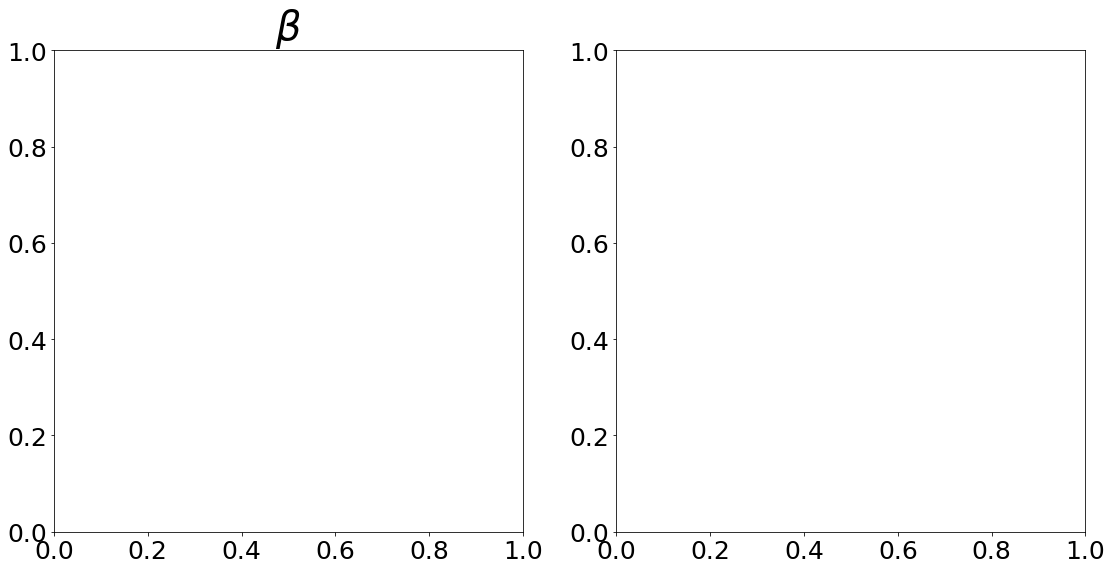

In [45]:
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams["font.size"] = 25

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.tight_layout()

ax[0].set_title(r"$\beta$", fontsize=40, weight='bold')
xbeta = np.linspace(np.min(energiesXTB_beta)-np.mean(energiesXTB_beta), np.max(energiesXTB_beta)-np.mean(energiesXTB_beta), 100)
ybeta=xbeta
ax[0].set_ylabel(r"baseline energiesXTB (eV)")
ax[0].set_xlabel(r"DFT energiesXTB (eV)")
ax[0].set_ylim(np.min(energiesXTB_beta)-np.mean(energiesXTB_beta), np.max(energiesXTB_beta)-np.mean(energiesXTB_beta))
ax[0].set_xlim(np.min(energiesXTB_beta)-np.mean(energiesXTB_beta), np.max(energiesXTB_beta)-np.mean(energiesXTB_beta))
ax[0].plot(xbeta, ybeta, color='red', linestyle='--', linewidth=4.0)
en_beta211 = np.array([e/2.0 for e in energiesXTB_beta211])
ax[0].scatter(energiesXTB_beta-np.mean(energiesXTB_beta), baseline_en_beta-np.mean(baseline_en_beta), s=20.0, label='32 atoms')
ax[0].scatter(energiesXTB_beta211-np.mean(energiesXTB_beta211), baseline_en_beta211-np.mean(baseline_en_beta211), s=50.0, color = 'orange', label='64 atoms')
ax[0].legend()

ax[1].set_title(r"$\gamma$", fontsize=40, weight='bold')
xgamma = np.linspace(np.min(energiesXTB_gamma)-np.mean(energiesXTB_gamma), np.max(energiesXTB_gamma)-np.mean(energiesXTB_gamma),100)
ygamma=xgamma

ax[1].set_ylim(np.min(energiesXTB_gamma)-np.mean(energiesXTB_gamma), np.max(energiesXTB_gamma)-np.mean(energiesXTB_gamma))
ax[1].set_xlim(np.min(energiesXTB_gamma)-np.mean(energiesXTB_gamma), np.max(energiesXTB_gamma)-np.mean(energiesXTB_gamma))
ax[1].plot(xgamma, ygamma, color='red', linestyle='--', linewidth=4.0)
ax[1].scatter(energiesXTB_gamma-np.mean(energiesXTB_gamma), baseline_en_gamma-np.mean(baseline_en_gamma), s=20.0)


fig.subplots_adjust(wspace=0.25)
plt.show()

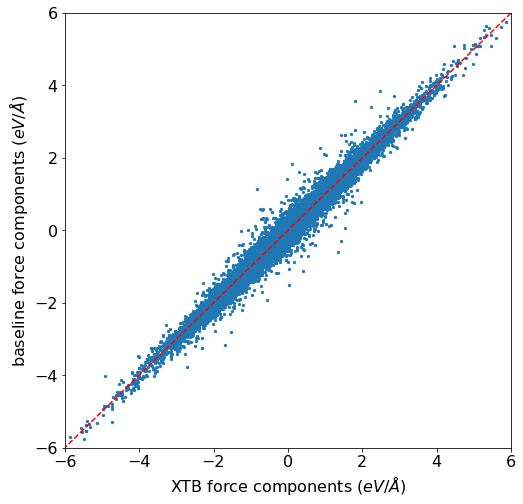

In [117]:
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 16
plt.xlabel(r"XTB force components ($eV/\AA$)")
plt.ylabel("baseline force components ($eV/\AA$)")
x = np.linspace(-8.0,8.0,100)
y = x
plt.plot(x, y, color='red', linestyle='--')
#plt.plot(f_test_fl, GAP_for_test_fl)
plt.xlim(-6.0, 6.0)
plt.ylim(-6.0, 6.0)
plt.scatter(baseline_forces[:,0,31], forcesXTB_fl[:], s=5.0)

# Training a committee on top of a ML baseline

In [228]:
ntraining = [10, 25, 50, 100, 200, 400, 800, 1500]
Nkvalidation = 1
ntrain = 1500
ids_validation = []
models = []
baseline = []


for k in range(Nkvalidation):
    ids = list(range(Ndataset))
    np.random.seed(20+k)
    np.random.shuffle(ids)
    ids_validation.append(ids)
    train_ids = [int(i) for i in ids[:ntrain]]
    frames_train = [LiPSdataset[ii] for ii in train_ids]

    en_train = [energiesXTB[ii] for ii in train_ids]
    en_train = np.array(en_train)

    f_train = [forcesXTB[ii] for ii in train_ids]
    f_train = np.array(f_train, dtype='object')
    f_train_fl = np.concatenate(f_train).ravel()
    #f_test_fl = np.concatenate(f_test).ravel()
    for nn in ntraining: 
        KnM_energies = np.array([KNM_base[ii,:] for ii in train_ids[:nn]])
        KnM_gradients = []

        for ii in train_ids[:nn]:
            ntotatoms_prec_ii=0
            for i, f in enumerate(LiPSdataset[:ii]):
                ntotatoms_prec_ii+=f.get_global_number_of_atoms()

            ntotatoms_ii = LiPSdataset[ii].get_global_number_of_atoms()
            Init = Ndataset + ntotatoms_prec_ii*3
            for ll in range(Init, Init+3*ntotatoms_ii): 
                KnM_gradients.append(KNM_base[ll, :])

        KnM_gradients = np.array(KnM_gradients)
        print(KnM_gradients.shape, KnM_energies.shape, en_train.shape, f_train_fl.shape, len(KnM_gradients[:, 0]))
        KnM = np.vstack([KnM_energies, KnM_gradients])
        baseline.append(train_gap_model(kernel_base, frames_train[:nn], KnM, X_sparse_baseline, en_train[:nn], energy_baseline_lstsq, 
                            grad_train=-f_train_fl[:len(KnM_gradients[:, 0])], 
                            lambdas=[1.0e-5*sigma_energies, 1.0e-5*sigma_forces], jitter=1e-13))

(816, 1000) (10, 1000) (1500,) (128064,) 816
(2112, 1000) (25, 1000) (1500,) (128064,) 2112
(4272, 1000) (50, 1000) (1500,) (128064,) 4272
(8448, 1000) (100, 1000) (1500,) (128064,) 8448
(16608, 1000) (200, 1000) (1500,) (128064,) 16608
(34128, 1000) (400, 1000) (1500,) (128064,) 34128
(67776, 1000) (800, 1000) (1500,) (128064,) 67776
(128064, 1000) (1500, 1000) (1500,) (128064,) 128064


In [229]:
baseline_energies = np.zeros((Ndataset, len(ntraining), Nkvalidation), dtype='float')
baseline_forces = np.zeros((len(forces_fl), len(ntraining), Nkvalidation), dtype='float')

In [230]:
i = 0
iforce = 0
for f in tqdm(LiPSdataset): 
    f.wrap(eps=1e-18)
    m = repr_bas_fsparse.transform(f)
    for k in range(Nkvalidation):
        for j, bmodel in enumerate(baseline[k*len(ntraining):(k+1)*len(ntraining)]):
            baseline_energies[i, j, k] = bmodel.predict(m)
            forces_tmp = bmodel.predict_forces(m)
            forces_tmp_fl = np.concatenate(forces_tmp).ravel()
            for l in range(iforce, iforce+len(forces_tmp_fl)):
                baseline_forces[l, j, k] = forces_tmp_fl[l-iforce]
    iforce += len(forces_tmp_fl)
    i += 1  

  0%|          | 0/1690 [00:00<?, ?it/s]

NameError: name 'baseline_energies' is not defined

In [93]:
baseline_forces.shape

NameError: name 'baseline_forces' is not defined

In [232]:
Nbeta = 0
Nbeta211 = 0
Ngamma = 0
baseline_en_beta = []
baseline_en_beta211 = []
baseline_en_gamma = []
for i in range(Ndataset):
    if(energies[i] > -3900.0):
        baseline_en_gamma.append(baseline_energies[i, 7, 0])
        Ngamma+=1
    if(energies[i] >= -8000.0 and energies[i] <= -7000.0):
        baseline_en_beta.append(baseline_energies[i, 7, 0])
        Nbeta+=1
    if(energies[i] <= -15000.0):
        baseline_en_beta211.append(baseline_energies[i, 7, 0]/2.0)
        Nbeta211+=1


score_beta = get_score(np.array(baseline_en_beta)-np.mean(baseline_en_beta), np.array(energiesXTB_beta)-np.mean(energiesXTB_beta))
RMSE_beta = score_beta['RMSE']

score_gamma = get_score(np.array(baseline_en_gamma)-np.mean(baseline_en_gamma), np.array(energiesXTB_gamma)-np.mean(energiesXTB_gamma))
RMSE_gamma = score_gamma['RMSE']

score_forces = get_score(np.array(baseline_forces[:,7,0]), np.array(forcesXTB_fl))
RMSE_forces = score_forces['RMSE']
print("RMSE beta = ", RMSE_beta*1000.0/(32.0), "meV/atom")
print("RMSE gamma = ", RMSE_gamma*1000.0/(16.0), "meV/atom")
print("RMSE forces = ", RMSE_forces*1000.0, "meV/force component = ", RMSE_forces/(sigma_forces)*100.0, "%")

RMSE beta =  4.748044171227885 meV/atom
RMSE gamma =  3.892714473062788 meV/atom
RMSE forces =  116.3471714776264 meV/force component =  16.636678497466047 %


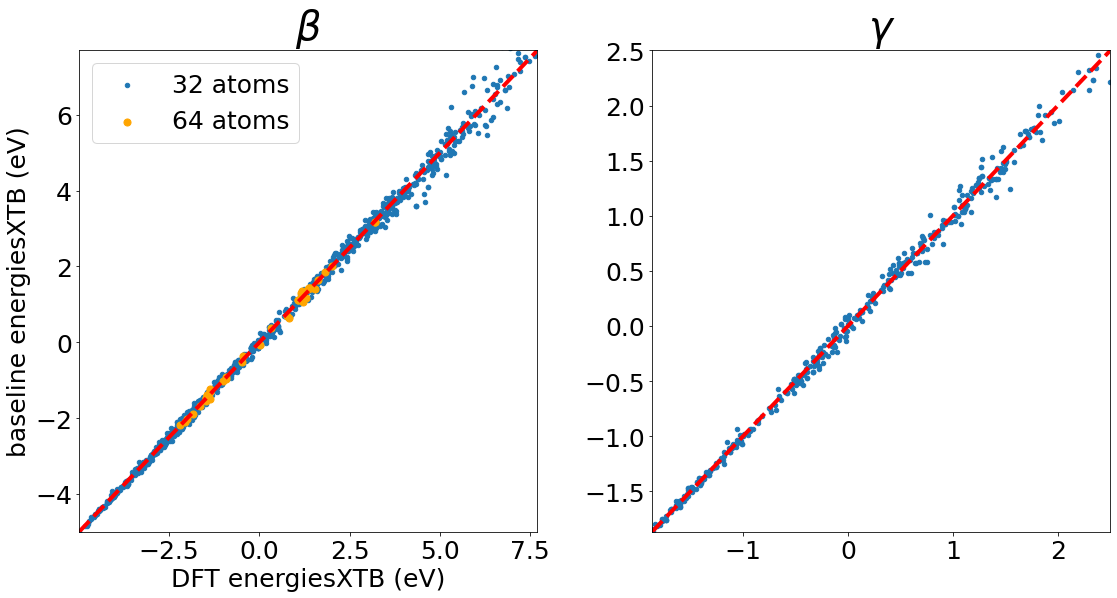

In [233]:
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams["font.size"] = 25

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.tight_layout()

ax[0].set_title(r"$\beta$", fontsize=40, weight='bold')
xbeta = np.linspace(np.min(energiesXTB_beta)-np.mean(energiesXTB_beta), np.max(energiesXTB_beta)-np.mean(energiesXTB_beta), 100)
ybeta=xbeta
ax[0].set_ylabel(r"baseline energiesXTB (eV)")
ax[0].set_xlabel(r"DFT energiesXTB (eV)")
ax[0].set_ylim(np.min(energiesXTB_beta)-np.mean(energiesXTB_beta), np.max(energiesXTB_beta)-np.mean(energiesXTB_beta))
ax[0].set_xlim(np.min(energiesXTB_beta)-np.mean(energiesXTB_beta), np.max(energiesXTB_beta)-np.mean(energiesXTB_beta))
ax[0].plot(xbeta, ybeta, color='red', linestyle='--', linewidth=4.0)
en_beta211 = np.array([e/2.0 for e in energiesXTB_beta211])
ax[0].scatter(energiesXTB_beta-np.mean(energiesXTB_beta), baseline_en_beta-np.mean(baseline_en_beta), s=20.0, label='32 atoms')
ax[0].scatter(energiesXTB_beta211-np.mean(energiesXTB_beta211), baseline_en_beta211-np.mean(baseline_en_beta211), s=50.0, color = 'orange', label='64 atoms')
ax[0].legend()

ax[1].set_title(r"$\gamma$", fontsize=40, weight='bold')
xgamma = np.linspace(np.min(energiesXTB_gamma)-np.mean(energiesXTB_gamma), np.max(energiesXTB_gamma)-np.mean(energiesXTB_gamma),100)
ygamma=xgamma

ax[1].set_ylim(np.min(energiesXTB_gamma)-np.mean(energiesXTB_gamma), np.max(energiesXTB_gamma)-np.mean(energiesXTB_gamma))
ax[1].set_xlim(np.min(energiesXTB_gamma)-np.mean(energiesXTB_gamma), np.max(energiesXTB_gamma)-np.mean(energiesXTB_gamma))
ax[1].plot(xgamma, ygamma, color='red', linestyle='--', linewidth=4.0)
ax[1].scatter(energiesXTB_gamma-np.mean(energiesXTB_gamma), baseline_en_gamma-np.mean(baseline_en_gamma), s=20.0)


fig.subplots_adjust(wspace=0.25)
plt.show()

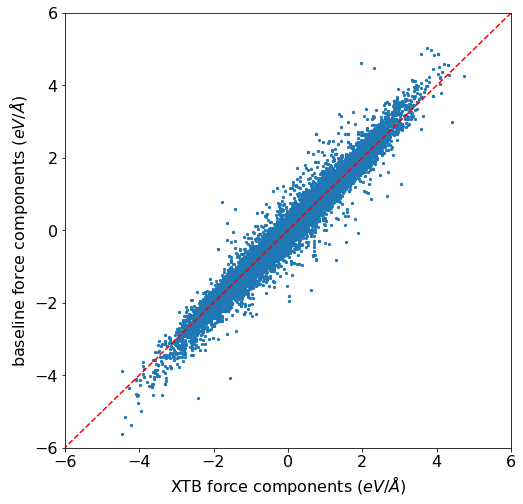

In [234]:
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 16
plt.xlabel(r"XTB force components ($eV/\AA$)")
plt.ylabel("baseline force components ($eV/\AA$)")
x = np.linspace(-8.0,8.0,100)
y = x
plt.plot(x, y, color='red', linestyle='--')
#plt.plot(f_test_fl, GAP_for_test_fl)
plt.xlim(-6.0, 6.0)
plt.ylim(-6.0, 6.0)
plt.scatter(baseline_forces[:,7,0], forcesXTB_fl[:], s=5.0)

In [235]:
RMSE_energies = np.zeros((len(ntraining), Nkvalidation), dtype='float')
RMSE_forces = np.zeros((len(ntraining), Nkvalidation), dtype='float')

In [236]:
print(len(ids_validation))
ids_validation = np.array(ids_validation)

1


In [237]:
for k in range(Nkvalidation):
    ids = ids_validation[0, :]
    train_ids = [int(ii) for ii in ids[:ntrain]]
    test_ids = [int(ii) for ii in ids[ntrain:]] 
    Ntest = len(test_ids)
    Ntrain = len(train_ids)
    Ntest_forces = 0
    for i in test_ids:
        Ntest_forces += 3*LiPSdataset[i].get_global_number_of_atoms()
    
    baseline_en_train= np.zeros((Ntrain, len(ntraining)), dtype='float')
    baseline_en_test = np.zeros((Ntest, len(ntraining)), dtype='float')
    baseline_forces_test = np.zeros((Ntest_forces, len(ntraining)), dtype='float')
    en_test = np.array([energiesXTB[ii] for ii in test_ids])
    en_train = np.array([energiesXTB[ii] for ii in train_ids])
    f_test = [forcesXTB[ii] for ii in test_ids]
    f_test_fl = np.concatenate(f_test).ravel()
    f_test_fl = np.array(f_test_fl)
    
    for j in range(len(ntraining)): 
        ncomponents = 0
        for n, ii in enumerate(test_ids):
            baseline_en_test[n, j] = baseline_energies[ii, j, k]
            Init = 0
            if ii == 0:
                 Init = 0
            else:
                for kk in range(ii): 
                    Init += 3*LiPSdataset[kk].get_global_number_of_atoms()
            natoms_ii = LiPSdataset[ii].get_global_number_of_atoms()
            for ll in range(Init, Init+3*natoms_ii):
                baseline_forces_test[ncomponents, j] = baseline_forces[ll, j, k]
                ncomponents += 1
            
        for n, ii in enumerate(train_ids):
            baseline_en_train[n, j] = baseline_energies[ii, j, k]
            
        rmse_en = 0
        for i, n in enumerate(test_ids):
            rmse_en += (en_test[i] - baseline_en_test[i,j])**2/(Ntest*(LiPSdataset[i].get_global_number_of_atoms())**2)
       
        RMSE_energies[j, k] = np.sqrt(rmse_en)
        rmse_f = 0
        for i in range(len(f_test_fl)):
            rmse_f += (f_test_fl[i] - baseline_forces_test[i,j])**2  
        RMSE_forces[j, k] = np.sqrt(rmse_f/(len(f_test_fl)))/(np.std(forces_fl))

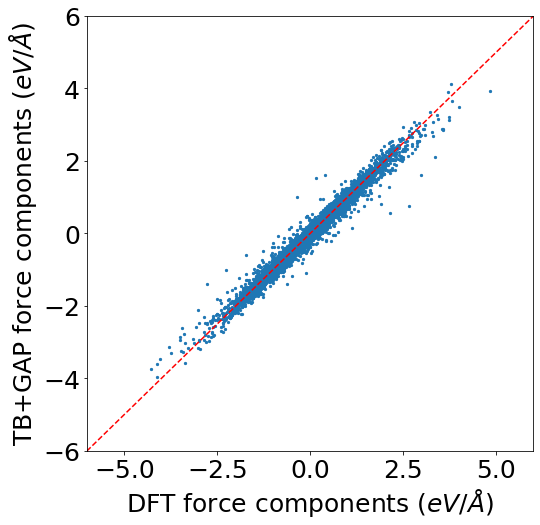

In [238]:
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 25
plt.xlabel(r"DFT force components ($eV/\AA$)")
plt.ylabel("TB+GAP force components ($eV/\AA$)")
x = np.linspace(-8.0,8.0,100)
y = x
plt.plot(x, y, color='red', linestyle='--')
#plt.plot(f_test_fl, GAP_for_test_fl)
plt.xlim(-6.0, 6.0)
plt.ylim(-6.0, 6.0)

plt.scatter(f_test_fl, baseline_forces_test[:,7], s=5.0)

In [239]:
print(np.mean(abs(f_test_fl[:] - baseline_forces_test[:,7])))

0.06948712408389682


In [240]:
rmse = np.sum((f_test_fl[:] - baseline_forces_test[:,7])**2/len(f_test_fl))
print(np.sqrt(rmse)/np.std(f_test_fl))

0.15643840008610269


In [241]:
print(RMSE_forces)

[[0.36451505]
 [0.26755255]
 [0.23849449]
 [0.18401765]
 [0.1651035 ]
 [0.15919962]
 [0.15880351]
 [0.15584808]]


In [242]:
print(RMSE_energies)

[[0.08631022]
 [0.05100019]
 [0.01221117]
 [0.0101184 ]
 [0.01134236]
 [0.00889454]
 [0.00936698]
 [0.00910979]]


In [243]:
score_forces = get_score(baseline_forces_test[:, 7], f_test_fl[:])
print(score_forces)
RMSE_forces_test = score_forces['RMSE']

{'MAE': 0.06948712408389682, 'RMSE': 0.10901315198198532, 'SUP': 1.890499230351293, 'R2': 0.9755270269785005, 'CORR': 0.9859760203111735}


In [244]:
score_energies = get_score(baseline_en_test[:, 7], en_test[:])
print(score_energies)
RMSE_energies_test = score_energies['RMSE']

{'MAE': 0.08085349154321551, 'RMSE': 0.14575662847277557, 'SUP': 1.0751297373067246, 'R2': 0.9999999289517875, 'CORR': 0.9992358722764956}


In [245]:
print(RMSE_forces)

[[0.36451505]
 [0.26755255]
 [0.23849449]
 [0.18401765]
 [0.1651035 ]
 [0.15919962]
 [0.15880351]
 [0.15584808]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


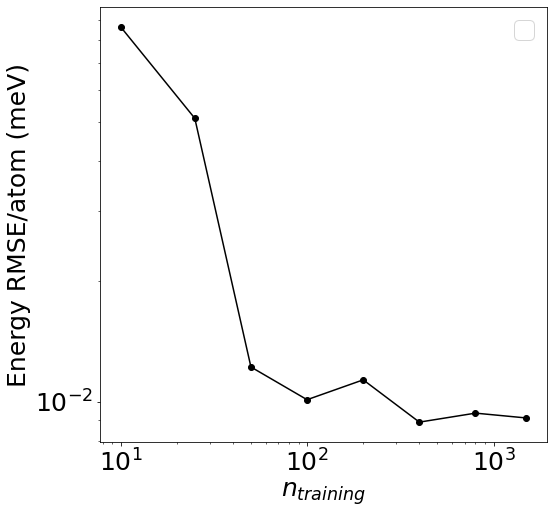

In [251]:
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 25

fig = plt.figure('')
#mpl.rc('font', **font)

# font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : 20}


grid = plt.GridSpec(1, 1, wspace=0.8, hspace=0.0)
ax_left = fig.add_subplot(grid[0, 0])

ax_left.set_xlabel(r"$n_{training}$")
ax_left.set_ylabel(r"Energy RMSE/atom (meV)")
ax_left.plot(ntraining, RMSE_energies, color = 'black')
ax_left.scatter(ntraining, RMSE_energies, color = 'black')
ax_left.set_xscale('log')
ax_left.set_yscale('log')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


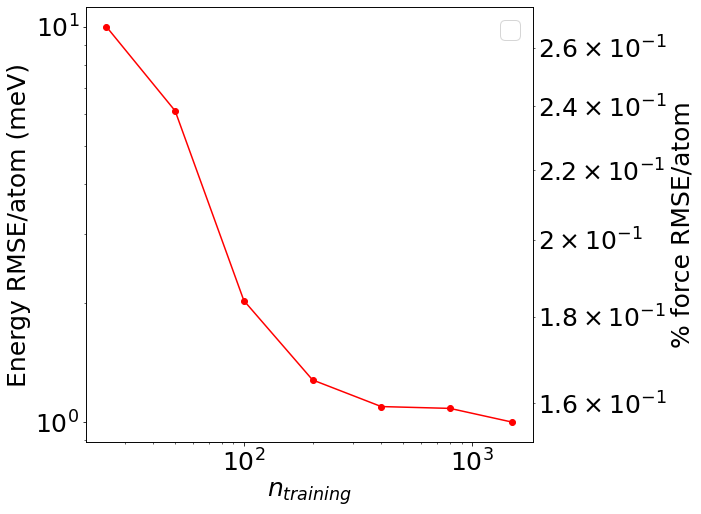

In [250]:
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 25

fig = plt.figure('')
#mpl.rc('font', **font)

# font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : 20}


grid = plt.GridSpec(1, 1, wspace=0.8, hspace=0.0)
ax_left = fig.add_subplot(grid[0, 0])

ax_right = ax_left.twinx()

ax_left.set_xlabel(r"$n_{training}$")
ax_left.set_ylabel(r"Energy RMSE/atom (meV)")
# ax_left.plot(ntraining, Mean_en_RMSE, color = 'black')
# ax_left.scatter(ntraining, Mean_en_RMSE, color = 'black')
ax_right.set_ylabel(r'% force RMSE/atom')
ax_right.plot(ntraining[1:], RMSE_forces[1:], color = 'red')
ax_right.scatter(ntraining[1:], RMSE_forces[1:], color = 'red')
ax_left.set_xscale('log')
ax_left.set_yscale('log')
ax_right.set_yscale('log')
#plt.yscale('log')
plt.legend()
#ax_right.legend()

# Training on PBEsol-atomic_energy

In [16]:
len(LiPSdataset)

2256

In [20]:
with open('GAPonPBE_rcut5_sigma0.3_2400sparsepoints_solvers.pk','rb') as fg:
    rcut_param = pk.load(fg)
ml_solvers = rcut_param['models']

FileNotFoundError: [Errno 2] No such file or directory: 'GAPonPBE_rcut5_sigma0.3_2400sparsepoints_solvers.pk'

In [36]:
solvers =['RKHS-QR']
#solvers =['nplstsqNone','nplstsq-1','scipylstsq_gelsd']
ml_solvers = {}

In [37]:
Ndataset

2256

In [38]:
#solvers = ['gaptools']
for solver in solvers:
    ntrain = 2000
    ntraining = [20,50,100, 200, 400, 800, 1500,2000]
    Nkvalidation = 1
    ids_validation = []
    models = []
    for k in range(Nkvalidation):
        #ids = range(ntrain)
        #np.random.seed(20+k)
        #np.random.shuffle(ids)
        #ids_validation.append(ids)
        train_ids = range(ntrain) #[int(i) for i in ids[:ntrain]]
        frames_train = [LiPSdataset[ii] for ii in train_ids]

        en_train = [energiesXTB_mencoes[ii] for ii in train_ids]
        en_train = np.array(en_train)

        f_train = [forcesXTB[ii] for ii in train_ids]
        f_train = np.array(f_train, dtype='object')
        f_train_fl = np.concatenate(f_train).ravel()
        #f_test_fl = np.concatenate(f_test).ravel()
        for nn in ntraining: 
            KnM_energies = np.array([KNM_base[ii,:] for ii in train_ids[:nn]])
            KnM_gradients = []

            for ii in train_ids[:nn]:
                ntotatoms_prec_ii=0
                for i, f in enumerate(LiPSdataset[:ii]):
                    ntotatoms_prec_ii+=f.get_global_number_of_atoms()

                ntotatoms_ii = LiPSdataset[ii].get_global_number_of_atoms()
                Init = Ndataset + ntotatoms_prec_ii*3
                for ll in range(Init, Init+3*ntotatoms_ii): 
                    KnM_gradients.append(KNM_base[ll, :])

            KnM_gradients = np.array(KnM_gradients)
            print(KnM_gradients.shape, KnM_energies.shape, en_train.shape, f_train_fl.shape, len(KnM_gradients[:, 0]))
            KnM = np.vstack([KnM_energies, KnM_gradients])
            models.append(train_gap_model(kernel_base, frames_train[:nn], KnM, X_sparse_baseline, en_train[:nn], energy_zero, 
                                grad_train=-f_train_fl[:len(KnM_gradients[:, 0])], 
                                          lambdas=[1e-07, 1e-06], jitter=1e-5,solver=solver))
    ml_solvers[solver] = models

(2016, 4000) (20, 4000) (2000,) (175200,) 2016
(4800, 4000) (50, 4000) (2000,) (175200,) 4800
(9456, 4000) (100, 4000) (2000,) (175200,) 9456
(18288, 4000) (200, 4000) (2000,) (175200,) 18288
(35616, 4000) (400, 4000) (2000,) (175200,) 35616
(70656, 4000) (800, 4000) (2000,) (175200,) 70656
(131376, 4000) (1500, 4000) (2000,) (175200,) 131376
(175200, 4000) (2000, 4000) (2000,) (175200,) 175200


In [39]:
print(len(models),Nkvalidation)

8 1


In [40]:
ids_validation = np.array(ids_validation)
print(ids_validation.shape)
#np.save("ids_validation.npy", ids_validation)

(0,)


In [41]:
GAP_energies = np.zeros((len(solvers),Ndataset, len(ntraining), Nkvalidation), dtype='float')
GAP_forces = np.zeros((len(solvers),len(forcesXTB_fl), len(ntraining), Nkvalidation), dtype='float')

In [43]:
print(len(LiPSdataset), len(forcesXTB_fl),len(models),len(forces_tmp_fl),GAP_forces.shape)

NameError: name 'forces_tmp_fl' is not defined

In [42]:
for isolv,solver in enumerate(solvers):
    models =  ml_solvers[solver]
    i = 0
    iforce = 0
    for f in tqdm(LiPSdataset): 
        f.wrap(eps=1e-18)
        m = repr_bas_fsparse.transform(f)
        for k in range(Nkvalidation):
            for j, gap in enumerate(models[k*len(ntraining):(k+1)*len(ntraining)]):
                GAP_energies[isolv,i, j, k] = gap.predict(m)
                forces_tmp = gap.predict_forces(m)
                forces_tmp_fl = np.concatenate(forces_tmp).ravel()
                for l in range(iforce, iforce+len(forces_tmp_fl)):
                    GAP_forces[isolv,l, j, k] = forces_tmp_fl[l-iforce]
        iforce += len(forces_tmp_fl)
        i += 1  

  0%|          | 0/2256 [00:00<?, ?it/s]

In [43]:
print(len(models), GAP_energies.shape),ml_solvers['RKHS-QR']

8 (1, 2256, 8, 1)


(None,
  <rascal.models.krr.KRR at 0x7fd38483a130>])

In [46]:
rcut8_param ={
    'repr_bas_fsparse':repr_bas_fsparse,
    'GAP_energies':GAP_energies,
    'GAP_forces':GAP_forces,
    'KnM':KnM,
    'KnM_gradients':KnM_gradients,
    'KNM_base':KNM_base,
    'kernel_base':kernel_base,
    'models':models,
    'ntraining':ntraining
    
}




In [47]:
#import pickle as pk
#with open('GAPonXTB_rcut8_sigma0.3_6ksnap.pk','wb') as fg:
#    pk.dump(rcut8_param,fg)

In [48]:
import pickle as pk
with open('GAPonPBEsol_rcut8_sigma0.3_4ksnap_rege-5regf-4.pk','wb') as fg:
    pk.dump(rcut8_param,fg)

In [44]:
Nbeta = 0
Nbeta211 = 0
Ngamma = 0

GAP_en_beta = []
GAP_en_beta211 = []
GAP_en_gamma = []

for i in range(Ndataset):
    #print(energies[i], Natoms[i])
    if(energiesXTB[i] > -1500.0):
        GAP_en_gamma.append(GAP_energies[i, 6, 0])
        Ngamma+=1
    if(energiesXTB[i] >= -2500.0 and energiesXTB[i] <= -1800.0):
        GAP_en_beta.append(GAP_energies[i, 6, 0])
        Nbeta+=1
    if(energiesXTB[i] <= -3000.0):
        GAP_en_beta211.append(GAP_energies[i, 6, 0]/2.0)
        Nbeta211+=1

print(Nbeta, Nbeta211, Ngamma)
print(Nbeta + Nbeta211 + Ngamma)

IndexError: index 1 is out of bounds for axis 0 with size 1

In [56]:
score_beta = get_score(np.array(GAP_en_beta), np.array(energiesXTB_beta))
print(score_beta)
RMSE_beta = score_beta['RMSE']

score_gamma = get_score(np.array(GAP_en_gamma), np.array(energiesXTB_gamma))
print(score_gamma)
RMSE_gamma = score_gamma['RMSE']

print("RMSE beta = ", RMSE_beta*1000.0/(32.0), "meV/atom")
print("RMSE gamma = ", RMSE_gamma*1000.0/(16.0), "meV/atom")

/home/tisi/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tisi/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation maximum which has no identity

ValueError: zero-size array to reduction operation minimum which has no identity

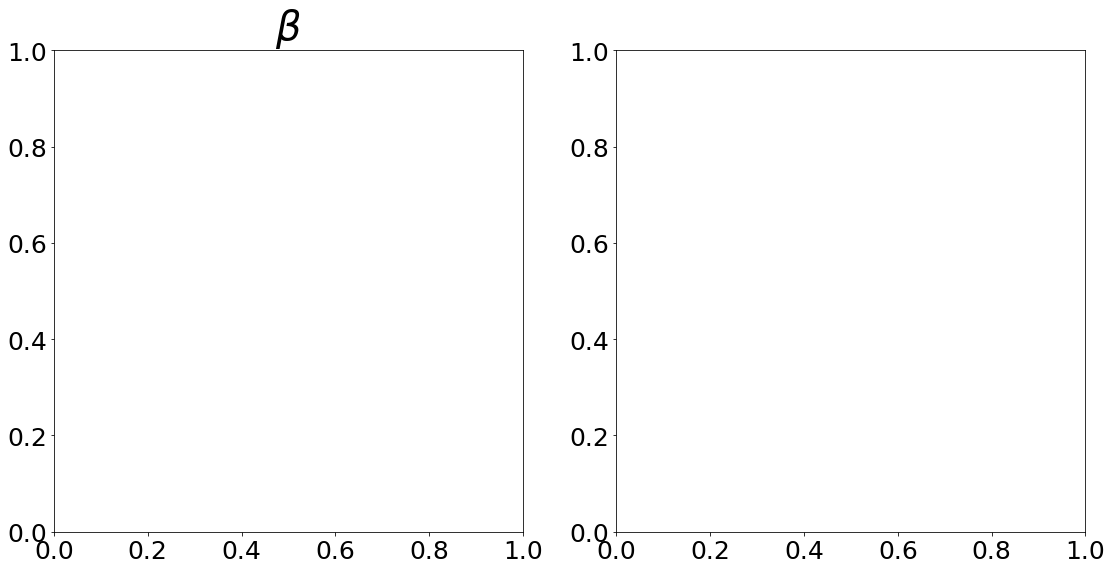

In [57]:
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams["font.size"] = 25

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.tight_layout()

ax[0].set_title(r"$\beta$", fontsize=40, weight='bold')
xbeta = np.linspace(np.min(energiesXTB_beta), np.max(energiesXTB_beta), 100)
ybeta=xbeta
ax[0].set_ylabel(r"TB+GAP energiesXTB (eV)")
ax[0].set_xlabel(r"DFT energies (eV)")
ax[0].set_ylim(np.min(energiesXTB_beta), np.max(energiesXTB_beta))
ax[0].set_xlim(np.min(energiesXTB_beta), np.max(energiesXTB_beta))
ax[0].plot(xbeta, ybeta, color='red', linestyle='--', linewidth=4.0)
en_beta211 = np.array([e/2.0 for e in energiesXTB_beta211])
ax[0].scatter(energiesXTB_beta, GAP_en_beta, s=20.0, label='32 atoms')
ax[0].scatter(en_beta211, GAP_en_beta211, s=50.0, color = 'orange', label='64 atoms')
ax[0].legend()

ax[1].set_title(r"$\gamma$", fontsize=40, weight='bold')
xgamma = np.linspace(np.min(energiesXTB_gamma), np.max(energiesXTB_gamma),100)
ygamma=xgamma

ax[1].set_ylim(np.min(energiesXTB_gamma), np.max(energiesXTB_gamma))
ax[1].set_xlim(np.min(energiesXTB_gamma), np.max(energiesXTB_gamma))
ax[1].plot(xgamma, ygamma, color='red', linestyle='--', linewidth=4.0)
ax[1].scatter(energiesXTB_gamma, GAP_en_gamma, s=20.0)


fig.subplots_adjust(wspace=0.25)
plt.show()

ValueError: x and y must be the same size

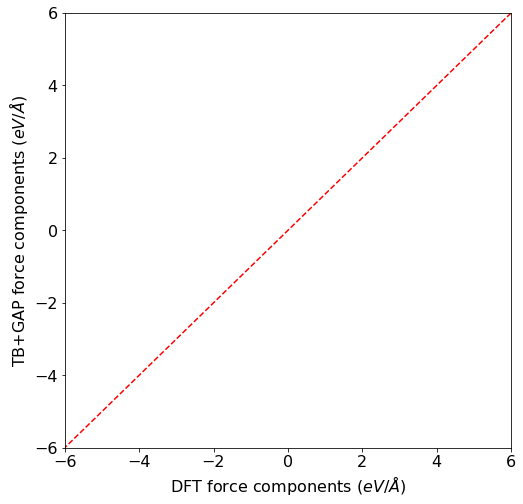

In [137]:
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 16
plt.xlabel(r"DFT force components ($eV/\AA$)")
plt.ylabel("TB+GAP force components ($eV/\AA$)")
x = np.linspace(-8.0,8.0,100)
y = x
plt.plot(x, y, color='red', linestyle='--')
#plt.plot(f_test_fl, GAP_for_test_fl)
plt.xlim(-6.0, 6.0)
plt.ylim(-6.0, 6.0)
plt.scatter(forcesXTB_fl, GAP_forces[:, 9, 0], s=5.0)

In [45]:
RMSE_energies = np.zeros((len(solvers),len(ntraining), Nkvalidation), dtype='float')
RMSE_forces = np.zeros((len(solvers),len(ntraining), Nkvalidation), dtype='float')

In [46]:
for k in range(Nkvalidation):
    ids = range(len(LiPSdataset))
    print(len(LiPSdataset))
    train_ids = [int(ii) for ii in ids[:ntrain]]
    test_ids = [int(ii) for ii in ids[ntrain:]] 
    Ntest = len(test_ids)
    Ntrain = len(train_ids)
    Ntest_forces = 0
    for i in test_ids:
        Ntest_forces += 3*LiPSdataset[i].get_global_number_of_atoms()
    
    GAP_en_train= np.zeros((len(solvers),Ntrain, len(ntraining)), dtype='float')
    GAP_en_test = np.zeros((len(solvers),Ntest, len(ntraining)), dtype='float')
    GAP_forces_test = np.zeros((len(solvers),Ntest_forces, len(ntraining)), dtype='float')
    en_test = np.array([energiesXTB[ii] for ii in test_ids])
    en_train = np.array([energiesXTB[ii] for ii in train_ids])
    f_test = [forcesXTB[ii] for ii in test_ids]
    f_test_fl = np.concatenate(f_test).ravel()
    f_test_fl = np.array(f_test_fl)
    for isolv,solver in enumerate(solvers):
        for j in tqdm(range(len(ntraining))): 
            ncomponents = 0
            for n, ii in enumerate(test_ids):
                GAP_en_test[isolv,n, j] = GAP_energies[isolv,ii, j, k]+energies_coesiveXTB[ii]
                Init = 0
                if ii == 0:
                     Init = 0
                else:
                    for kk in range(ii): 
                        Init += 3*LiPSdataset[kk].get_global_number_of_atoms()
                natoms_ii = LiPSdataset[ii].get_global_number_of_atoms()

                for ll in range(Init, Init+3*natoms_ii):
                    GAP_forces_test[isolv,ncomponents, j] = GAP_forces[isolv,ll, j, k]
                    ncomponents += 1

            for n, ii in enumerate(train_ids):
                GAP_en_train[isolv,n, j] = GAP_energies[isolv,ii, j, k]+energies_coesiveXTB[ii]

            rmse_en = 0
            for i, n in enumerate(test_ids):
                rmse_en += (en_test[i] - GAP_en_test[isolv,i,j])**2/(Ntest*(LiPSdataset[i].get_global_number_of_atoms())**2)

            RMSE_energies[isolv,j, k] = np.sqrt(rmse_en)
            rmse_f = 0
            for i in range(len(f_test_fl)):
                rmse_f += (f_test_fl[i] - GAP_forces_test[isolv,i,j])**2  
            RMSE_forces[isolv,j, k] = np.sqrt(rmse_f/(len(f_test_fl)))/(np.std(forcesXTB_fl))
            
            

2256


  0%|          | 0/8 [00:00<?, ?it/s]

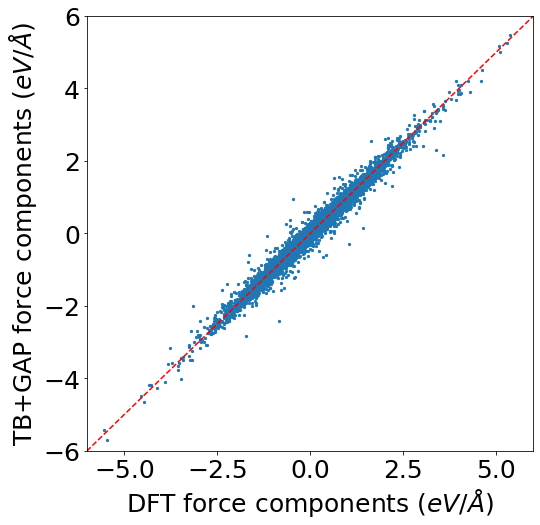

In [47]:
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 25
plt.xlabel(r"DFT force components ($eV/\AA$)")
plt.ylabel("TB+GAP force components ($eV/\AA$)")
x = np.linspace(-8.0,8.0,100)
y = x
plt.plot(x, y, color='red', linestyle='--')
#plt.plot(f_test_fl, GAP_for_test_fl)
plt.xlim(-6.0, 6.0)
plt.ylim(-6.0, 6.0)
for isolv,solver in enumerate(solvers):
    plt.scatter(f_test_fl, GAP_forces_test[isolv,:,5], s=5.0)

In [48]:
for isolv,solver in enumerate(solvers):
    print(np.mean(abs(f_test_fl[:] - GAP_forces_test[isolv,:,-1])))

0.058509963470891074


In [49]:
for isolv,solver in enumerate(solvers):
    print(np.mean(abs(f_test_fl[:] - GAP_forces_test[isolv,:,-1])))

0.058509963470891074


In [50]:
for isolv,solver in enumerate(solvers):
    rmse = np.sum((f_test_fl[:] - GAP_forces_test[isolv,:,-1])**2/len(f_test_fl))
    print(np.sqrt(rmse)/np.std(f_test_fl))

0.1307018935632209


In [51]:
print(RMSE_forces*np.std(forcesXTB_fl))

[[[0.2608318 ]
  [0.27456121]
  [0.14107094]
  [0.11505238]
  [0.10193858]
  [0.09716318]
  [0.09315865]
  [0.09329141]]]


In [52]:
print(RMSE_energies)

[[[0.05480398]
  [0.02191553]
  [0.00680229]
  [0.00563292]
  [0.00448146]
  [0.00432179]
  [0.00400578]
  [0.00400412]]]


In [53]:
score_forces = get_score(GAP_forces_test[:, -1], f_test_fl[:])
print(score_forces)
RMSE_forces_test = score_forces['RMSE']

ValueError: operands could not be broadcast together with shapes (1,8) (22464,) 

In [40]:
score_energies = get_score(GAP_en_test[:, -1], en_test[:])
print(score_energies)
RMSE_energies_test = score_energies['RMSE']

ValueError: operands could not be broadcast together with shapes (5,7) (256,) 

In [54]:
print(RMSE_forces)

[[[0.35946076]
  [0.37838169]
  [0.19441443]
  [0.15855741]
  [0.14048485]
  [0.13390373]
  [0.12838495]
  [0.12856792]]]


In [55]:
nsolvers= len(solvers)
Mean_en_RMSE  = np.zeros((nsolvers,len(ntraining)), dtype='float')
Sigma_en_RMSE = np.zeros((nsolvers,len(ntraining)), dtype='float')

Mean_force_RMSE  = np.zeros((nsolvers,len(ntraining)), dtype='float')
Sigma_force_RMSE = np.zeros((nsolvers,len(ntraining)), dtype='float')

for isolv,solver in enumerate(solvers):
    for i, n in enumerate(ntraining):
        Mean_en_RMSE    [isolv,i] = np.mean(RMSE_energies[isolv,i, :])*1000.0
        Sigma_en_RMSE   [isolv,i] = np.std( RMSE_energies[isolv,i, :], ddof = 1)*1000.0
        Mean_force_RMSE [isolv,i] = np.mean(RMSE_forces  [isolv,i, :])*100.0
        Sigma_force_RMSE[isolv,i] = np.std( RMSE_forces  [isolv,i, :], ddof = 1)*100.0

/home/tisi/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/tisi/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [59]:
rcut_param ={
    'repr_bas_fsparse':repr_bas_fsparse,
    'GAP_energies':GAP_energies,
    'GAP_forces':GAP_forces,
    'RMSE_forces':RMSE_forces,
    'RMSE_energies':RMSE_energies,
    'Mean_en_RMSE':Mean_en_RMSE,
    'Mean_force_RMSE':Mean_force_RMSE,
    'ntraining':ntraining,
    'models': ml_solvers,
    'solvers': solvers
}

In [77]:
#import pickle as pk
#with open('GAPonPBE_rcut5_sigma0.3_solvers.pk','wb') as fg:
#    pk.dump(rcut_param,fg)

In [70]:
#import pickle as pk
#with open('GAPonPBE_rcut5_sigma0.3_2400sparsepoints_solvers.pk','wb') as fg:
#    pk.dump(rcut_param,fg)

In [60]:
import pickle as pk
with open('GAPonPBE_rcut5_sigma0.3_600sparsefeature_4000sparseenviroment_solvers.pk','wb') as fg:
    pk.dump(rcut_param,fg)

In [102]:
#import pickle as pk
#with open('GAPonPBE_rcut5_sigma0.3_600sparsefeature_3000sparseenviroment_solvers.pk','wb') as fg:
#    pk.dump(rcut_param,fg)

In [57]:
#import pickle as pk
#with open('GAPonPBE_rcut5_sigma0.3_600sparsefeature_4000sparseenviroment_solvers.pk','wb') as fg:
#    pk.dump(rcut_param,fg)

In [64]:
#import pickle as pk
#with open('GAPonPBE_rcut5_sigma0.3_600sparsefeature_8000sparseenviroment_solvers.pk','wb') as fg:
#    pk.dump(rcut_param,fg)

In [59]:
with open('GAPonPBE_rcut5_sigma0.3_600sparsefeature_4000sparseenviroment_solvers.pk','rb') as fg:
    rcut_param_600 = pk.load(fg)
    
repr_bas_fsparse = rcut_param_600['repr_bas_fsparse'] 
GAP_energies = rcut_param_600['GAP_energies']
GAP_forces = rcut_param_600['GAP_forces']
RMSE_forces = rcut_param_600['RMSE_forces']
RMSE_energies = rcut_param_600['RMSE_energies']
Mean_en_RMSE = rcut_param_600['Mean_en_RMSE']
Mean_force_RMSE = rcut_param_600['Mean_force_RMSE']
ntraining = rcut_param_600['ntraining']
ml_solvers = rcut_param_600['models']
solvers = rcut_param_600['solvers'] 

In [71]:
rcut_param_600['models'].keys(),solvers

(dict_keys(['RKHS-QR']), ['RKHS-QR'])

In [61]:
Sigma_en_RMSE = np.array(Sigma_en_RMSE)
print(Sigma_en_RMSE,Mean_en_RMSE)

[[nan nan nan nan nan nan nan nan]] [[54.13965699 32.44734688  6.58263897  5.45022869  4.53133406  4.21769753
   3.93926112  3.93347607]]


In [62]:
print(ntraining)

[20, 50, 100, 200, 400, 800, 1500, 2000]


In [63]:
print(Mean_force_RMSE)
print(((23.15808166-21.72811231)/(6000.0)**(-1))*12.0)

[[35.28498772 44.30735477 19.67353999 16.21352809 14.08154896 13.2946501
  12.71664928 12.70567226]]
102957.79320000001


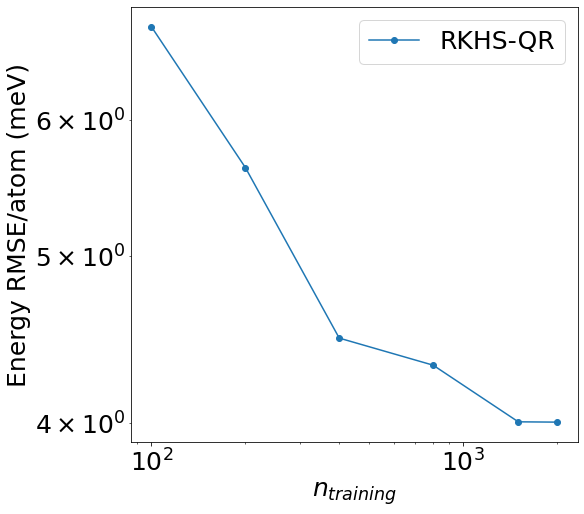

In [56]:
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 25

fig = plt.figure('')
#mpl.rc('font', **font)

# font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : 20}


grid = plt.GridSpec(1, 1, wspace=0.8, hspace=0.0)
ax_left = fig.add_subplot(grid[0, 0])
#Mean_en_RMSE_600 = rcut_param_600['Mean_en_RMSE']
#solvers_600 = ['nplstsqNone', 'nplstsq-1', 'scipysolve', 'npsolve']

ax_left.set_xlabel(r"$n_{training}$")
ax_left.set_ylabel(r"Energy RMSE/atom (meV)")
for isolv,solver in enumerate(solvers):
    #ax_left.scatter(ntraining[2:], Mean_en_RMSE[isolv,2:])
    ax_left.loglog(ntraining[2:], Mean_en_RMSE[isolv,2:],marker='o',label=solver)
#for isolv,solver in enumerate(solvers_600):
#    ax_left.loglog(ntraining[2:], Mean_en_RMSE_600[isolv,2:],marker='o',label=solver+'_600sp')

#ax_left.set_xscale('log')
#ax_left.set_yscale('log')

plt.legend()

In [164]:
solvers

['RKHS-QR']

/tmp/ipykernel_1999000/2783416338.py:37: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax_left.set_xlim(0,8000)


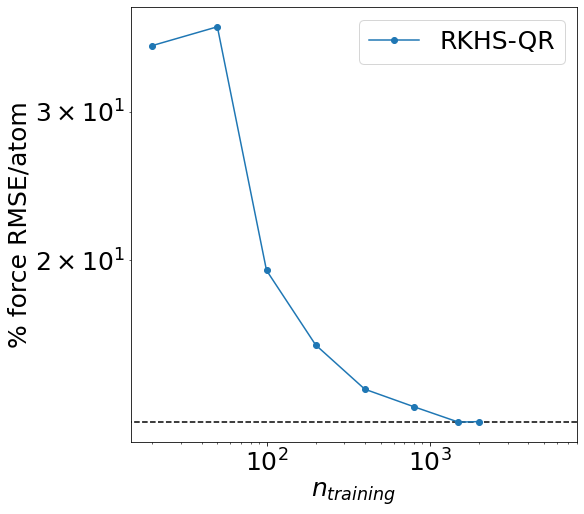

In [57]:
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 25

fig = plt.figure('')
#mpl.rc('font', **font)

# font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : 20}


grid = plt.GridSpec(1, 1, wspace=0.8, hspace=0.0)
ax_left = fig.add_subplot(grid[0, 0])

#ax_right = ax_left.twinx()

ax_left.set_xlabel(r"$n_{training}$")
#ax_left.set_ylabel(r"Energy RMSE/atom (meV)")
#ax_left.errorbar(ntraining[2:], Mean_en_RMSE[2:], yerr=Sigma_en_RMSE[2:], color = 'black', label = "energy")
ax_left.set_ylabel(r'% force RMSE/atom')
#ax_left.errorbar(ntraining[2:], Mean_force_RMSE[2:], yerr=Sigma_force_RMSE[2:], color = 'red', label = "forces")
#ax_left.set_xscale('log')

for isolv,solver in enumerate(solvers):
    #if solver == 'npsolve': continue
    ax_left.loglog([-1,9000],[Mean_force_RMSE[isolv,-1],Mean_force_RMSE[isolv,-1]], label = "",marker='',ls='--',color='black')
    ax_left.loglog(ntraining[:], Mean_force_RMSE[isolv,:], label = solver,marker='o')
    #ax_left.loglog(zeta2_Mean_force_RMSE[:,0], zeta2_Mean_force_RMSE[:,1], label = "forces",marker='o')
    



#ax_left.set_yscale('log')
#ax_right.set_yscale('log')
#plt.yscale('log')
#ax_left.set_ylim((0,50))
ax_left.set_xlim(0,8000)
plt.legend()
ax_left.legend(loc = 0)

In [58]:
for isolv,solver in enumerate(solvers):
    print(solver, Mean_force_RMSE[isolv,-1])

RKHS-QR 12.85679197759426


In [167]:
rcut_param ={
    'GAP_energies':GAP_energies,
    'GAP_forces':GAP_forces,
    'RMSE_forces':RMSE_forces,
    'RMSE_energies':RMSE_energies,
    'Mean_en_RMSE':Mean_en_RMSE,
    'Mean_force_RMSE':Mean_force_RMSE,
    'ntraining':ntraining,
    'solvers': solvers
}


#with open('RMSE_GAPonPBE_rcut5_sigma0.3_600sparsefeature_8000sparseenviroment_solvers.pk','wb') as fg:
with open('RMSE_GAPonPBE_menocoesiveenergy_rcut5_sigma0.3_600sparsefeature_4000sparseenviroment_solvers.pk','wb') as fg:
    pk.dump(rcut_param,fg)

In [168]:
dump_obj('model-PBEsol-menocoesiveenergy-rcut5_sigma0.3-4000sparseenv-1500traindata.json',ml_solvers['RKHS-QR'][-2])

In [65]:
dump_obj?

In [169]:
ml_solvers['RKHS-QR']

In [172]:
LiPSdataset[0].info

{'energy': -3876.119695710878,
 'stress': array([[ 0.00357531,  0.00194282,  0.00199883],
        [ 0.00194282,  0.01093618, -0.00203647],
        [ 0.00199883, -0.00203647,  0.01275137]]),
 'free_energy': -3876.119695710878}

In [1]:
pwd

'/scratch/tisi/LIPS_dataset_alpha_beta_gamma'